In [122]:
#import libraries
import pandas as pd
import json
import datetime
import numpy as np
import matplotlib.pyplot as plt


In [8]:
#gathering data from the three resourses
df=pd.read_csv('twitter-archive-enhanced.csv')
df2=pd.read_csv('image-predictions.tsv',sep='\t')
df_list = []
with open('tweet-json.txt', 'r') as file:
    for line in file:
        tweet = json.loads(line)
        tweet_id = tweet['id']
        retweet_count = tweet['retweet_count']
        fav_count = tweet['favorite_count']
        user_count = tweet['user']['followers_count']
        df_list.append({'tweet_id':tweet_id,
                       'retweet_count': retweet_count,
                       'favorite_count': fav_count,
                       'followers_count':user_count})
api_df= pd.DataFrame(df_list)

In [3]:
#check the head and info for each df
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [5]:
df2.head()

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True


In [6]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [9]:
api_df.head()

,tweet_id,retweet_count,favorite_count,followers_count
0,892420643555336193,8853,39467,3200889
1,892177421306343426,6514,33819,3200889
2,891815181378084864,4328,25461,3200889
3,891689557279858688,8964,42908,3200889
4,891327558926688256,9774,41048,3200889


In [10]:
api_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   tweet_id         2354 non-null   int64
 1   retweet_count    2354 non-null   int64
 2   favorite_count   2354 non-null   int64
 3   followers_count  2354 non-null   int64
dtypes: int64(4)
memory usage: 73.7 KB


In [27]:
#acsses data in the first df
#the range of numerator values
df['rating_numerator'].value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [28]:
#the range of denominator values
df['rating_denominator'].value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [29]:
#set the variable rate to the rate,rate=num/deno
rate=df['rating_numerator']/df['rating_denominator']
#the range of rates
rate.value_counts()

1.200000      562
1.100000      469
1.000000      463
1.300000      351
0.900000      157
0.800000      102
0.700000       54
1.400000       54
0.500000       38
0.600000       32
0.300000       19
0.400000       15
0.200000       11
0.100000        8
42.000000       2
1.500000        2
0.000000        2
7.500000        2
0.818182        2
1.250000        1
66.600000       1
inf             1
1.700000        1
3.428571        1
0.636364        1
2.700000        1
0.733333        1
2.600000        1
18.200000       1
177.600000      1
dtype: int64

In [31]:
#drop the rate values out of range 
df.drop(df.loc[rate>=2.5].index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345 entries, 0 to 2355
Data columns (total 18 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2345 non-null   int64  
 1   in_reply_to_status_id       74 non-null     float64
 2   in_reply_to_user_id         74 non-null     float64
 3   timestamp                   2345 non-null   object 
 4   source                      2345 non-null   object 
 5   text                        2345 non-null   object 
 6   retweeted_status_id         180 non-null    float64
 7   retweeted_status_user_id    180 non-null    float64
 8   retweeted_status_timestamp  180 non-null    object 
 9   expanded_urls               2290 non-null   object 
 10  rating_numerator            2345 non-null   int64  
 11  rating_denominator          2345 non-null   int64  
 12  name                        2345 non-null   object 
 13  doggo                       2345 

In [33]:
#new column for rates
df['rate']=rate
df['rate'].value_counts()

1.200000    562
1.100000    469
1.000000    463
1.300000    351
0.900000    157
0.800000    102
1.400000     54
0.700000     54
0.500000     38
0.600000     32
0.300000     19
0.400000     15
0.200000     11
0.100000      8
0.818182      2
0.000000      2
1.500000      2
1.700000      1
0.733333      1
0.636364      1
1.250000      1
Name: rate, dtype: int64

In [11]:
#the 4 columns of types are tidness issue(multiple columns for one variable) and "none"value the most
df['doggo'].value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [12]:
df['floofer'].value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [13]:
df['pupper'].value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [14]:
df['puppo'].value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [15]:
#melt the 4 columns in one
df['type']=df['doggo']+df['floofer']+df['pupper']+df['puppo']
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,type
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,NoneNoneNoneNone
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,NoneNoneNoneNone
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,NoneNoneNoneNone
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,NoneNoneNoneNone
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,NoneNoneNoneNone


In [16]:
#check now the new column values
df['type'].value_counts()

NoneNoneNoneNone        1976
NoneNonepupperNone       245
doggoNoneNoneNone         83
NoneNoneNonepuppo         29
doggoNonepupperNone       12
NoneflooferNoneNone        9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: type, dtype: int64

In [19]:
#replace values in the new column
df['type'].replace({'NoneNoneNoneNone':'other',
                   'NoneNonepupperNone':'pupper',
                   'doggoNoneNoneNone':'doggo',
                   'NoneflooferNoneNone':'floofer',
                   'NoneNoneNonepuppo':'puppo'},inplace=True)
df['type'].value_counts()

other                   1976
pupper                   245
doggo                     83
puppo                     29
doggoNonepupperNone       12
floofer                    9
doggoNoneNonepuppo         1
doggoflooferNoneNone       1
Name: type, dtype: int64

In [20]:
#there are 1 doggo&floofer, 1 doggo&puppo and 12 doggo&pupper, get their text to define the type
D_F=df['type']
dc=df.loc[D_F=="doggoflooferNoneNone"]
dc['text']

200    At first I thought this was a shy doggo, but i...
Name: text, dtype: object

In [22]:
df['type'].replace({'doggoflooferNoneNone':'floofer'},inplace=True)
df['type'].value_counts()

other                  1976
pupper                  245
doggo                    83
puppo                    29
doggoNonepupperNone      12
floofer                  10
doggoNoneNonepuppo        1
Name: type, dtype: int64

In [23]:
dc=df.loc[D_F=="doggoNoneNonepuppo"]
dc['text']

191    Here's a puppo participating in the #ScienceMa...
Name: text, dtype: object

In [24]:
df['type'].replace({'doggoNoneNonepuppo':'puppo'},inplace=True)
df['type'].value_counts()

other                  1976
pupper                  245
doggo                    83
puppo                    30
doggoNonepupperNone      12
floofer                  10
Name: type, dtype: int64

In [74]:
dc=df.loc[D_F=="doggoNonepupperNone"]
dc['text']

460    This is Dido. She's playing the lead role in "...
531    Here we have Burke (pupper) and Dexter (doggo)...
565    Like doggo, like pupper version 2. Both 11/10 ...
575    This is Bones. He's being haunted by another d...
705    This is Pinot. He's a sophisticated doggo. You...
733    Pupper butt 1, Doggo 0. Both 12/10 https://t.c...
778    RT @dog_rates: Like father (doggo), like son (...
822    RT @dog_rates: This is just downright precious...
889    Meet Maggie &amp; Lila. Maggie is the doggo, L...
956    Please stop sending it pictures that don't eve...
Name: text, dtype: object

In [26]:
df.at[460,'type']='doggo'
df.at[705,'type']='doggo'
df.at[575,'type']='pupper'
df.at[531,'type']='doggo&pupper'
df.at[565,'type']='doggo&pupper'
df.at[778,'type']='doggo&pupper'
df.at[822,'type']='doggo&pupper'
df.at[889,'type']='doggo&pupper'
df.at[191,'type']='puppo'
df['type'].value_counts()

other                  1976
pupper                  246
doggo                    85
puppo                    30
floofer                  10
doggo&pupper              5
doggoNonepupperNone       4
Name: type, dtype: int64

In [75]:
the_main_df.at[956,'type']='doggo&pupper'

In [35]:
#check name column
df['name']

0        Phineas
1          Tilly
2         Archie
3          Darla
4       Franklin
          ...   
2351        None
2352           a
2353           a
2354           a
2355        None
Name: name, Length: 2345, dtype: object

In [42]:
#replace 'a','an'and'none'values
df['name'].replace({'None':'no name'},inplace=True)
df['name'].value_counts()

no name    801
Charlie     12
Cooper      11
Lucy        11
Oliver      11
          ... 
Jameson      1
Kara         1
Tycho        1
Frönq        1
Mauve        1
Name: name, Length: 954, dtype: int64

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2345 non-null   int64  
 1   in_reply_to_status_id       74 non-null     float64
 2   in_reply_to_user_id         74 non-null     float64
 3   timestamp                   2345 non-null   object 
 4   source                      2345 non-null   object 
 5   text                        2345 non-null   object 
 6   retweeted_status_id         180 non-null    float64
 7   retweeted_status_user_id    180 non-null    float64
 8   retweeted_status_timestamp  180 non-null    object 
 9   expanded_urls               2290 non-null   object 
 10  rating_numerator            2345 non-null   int64  
 11  rating_denominator          2345 non-null   int64  
 12  name                        2345 non-null   object 
 13  doggo                       2345 

In [49]:
#datatypes of columns
df['timestamp']= pd.to_datetime(df['timestamp'])
df['retweeted_status_timestamp']= pd.to_datetime(df['retweeted_status_timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2345 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2345 non-null   int64              
 1   in_reply_to_status_id       74 non-null     float64            
 2   in_reply_to_user_id         74 non-null     float64            
 3   timestamp                   2345 non-null   datetime64[ns, UTC]
 4   source                      2345 non-null   object             
 5   text                        2345 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    datetime64[ns, UTC]
 9   expanded_urls               2290 non-null   object             
 10  rating_numerator            2345 non-null   int64           

In [50]:
df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,type,rate
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None,other,1.3
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None,other,1.3
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None,other,1.2
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None,other,1.3
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None,other,1.2


In [51]:
#drop retweeted tweets
re=df['retweeted_status_id']
df.drop(df.loc[df['tweet_id'].isin(re)].index,inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2234 entries, 0 to 2355
Data columns (total 19 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    2234 non-null   int64              
 1   in_reply_to_status_id       74 non-null     float64            
 2   in_reply_to_user_id         74 non-null     float64            
 3   timestamp                   2234 non-null   datetime64[ns, UTC]
 4   source                      2234 non-null   object             
 5   text                        2234 non-null   object             
 6   retweeted_status_id         180 non-null    float64            
 7   retweeted_status_user_id    180 non-null    float64            
 8   retweeted_status_timestamp  180 non-null    datetime64[ns, UTC]
 9   expanded_urls               2179 non-null   object             
 10  rating_numerator            2234 non-null   int64           

In [52]:
# merge the first and second df and drop the tweets without images
main_df=pd.merge(df, df2, how='inner', on=["tweet_id"])
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1969 entries, 0 to 1968
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1969 non-null   int64              
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   1969 non-null   datetime64[ns, UTC]
 4   source                      1969 non-null   object             
 5   text                        1969 non-null   object             
 6   retweeted_status_id         81 non-null     float64            
 7   retweeted_status_user_id    81 non-null     float64            
 8   retweeted_status_timestamp  81 non-null     datetime64[ns, UTC]
 9   expanded_urls               1969 non-null   object             
 10  rating_numerator            1969 non-null   int64           

In [54]:
# merge the first and second df with the third 
the_main_df=pd.merge(main_df, api_df, how='inner', on=["tweet_id"])
the_main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1967 non-null   int64              
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   1967 non-null   datetime64[ns, UTC]
 4   source                      1967 non-null   object             
 5   text                        1967 non-null   object             
 6   retweeted_status_id         79 non-null     float64            
 7   retweeted_status_user_id    79 non-null     float64            
 8   retweeted_status_timestamp  79 non-null     datetime64[ns, UTC]
 9   expanded_urls               1967 non-null   object             
 10  rating_numerator            1967 non-null   int64           

In [55]:
#change datatype for tweets id cause it's not int 'we won't use it in mathematical equations'
the_main_df["tweet_id"] =the_main_df['tweet_id'].astype('object')
the_main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1967 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   1967 non-null   datetime64[ns, UTC]
 4   source                      1967 non-null   object             
 5   text                        1967 non-null   object             
 6   retweeted_status_id         79 non-null     float64            
 7   retweeted_status_user_id    79 non-null     float64            
 8   retweeted_status_timestamp  79 non-null     datetime64[ns, UTC]
 9   expanded_urls               1967 non-null   object             
 10  rating_numerator            1967 non-null   int64           

In [56]:
#rename p1,p2 and p3 columns
the_main_df.rename(columns = {'p1':'first_prediction'}, inplace = True)
the_main_df.rename(columns = {'p2':'second_prediction'}, inplace = True)
the_main_df.rename(columns = {'p3':'third_prediction'}, inplace = True)
the_main_df.rename(columns = {'p1_conf':'prediction1_confident'}, inplace = True)
the_main_df.rename(columns = {'p2_conf':'prediction2_confident'}, inplace = True)
the_main_df.rename(columns = {'p3_conf':'prediction3_confident'}, inplace = True)
the_main_df.rename(columns = {'p1_dog':'prediction1_test'}, inplace = True)
the_main_df.rename(columns = {'p2_dog':'prediction2_test'}, inplace = True)
the_main_df.rename(columns = {'p3_dog':'prediction3_test'}, inplace = True)
the_main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1967 entries, 0 to 1966
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype              
---  ------                      --------------  -----              
 0   tweet_id                    1967 non-null   object             
 1   in_reply_to_status_id       23 non-null     float64            
 2   in_reply_to_user_id         23 non-null     float64            
 3   timestamp                   1967 non-null   datetime64[ns, UTC]
 4   source                      1967 non-null   object             
 5   text                        1967 non-null   object             
 6   retweeted_status_id         79 non-null     float64            
 7   retweeted_status_user_id    79 non-null     float64            
 8   retweeted_status_timestamp  79 non-null     datetime64[ns, UTC]
 9   expanded_urls               1967 non-null   object             
 10  rating_numerator            1967 non-null   int64           

In [57]:
the_main_df.head()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,...,prediction1_test,second_prediction,prediction2_confident,prediction2_test,third_prediction,prediction3_confident,prediction3_test,retweet_count,favorite_count,followers_count
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892420643...,...,False,bagel,0.085851,False,banana,0.076110,False,8853,39467,3200889
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaT,https://twitter.com/dog_rates/status/892177421...,...,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819,3200889
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891815181...,...,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461,3200889
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891689557...,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908,3200889
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaT,https://twitter.com/dog_rates/status/891327558...,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048,3200889


In [59]:
#drop unimportant columns
the_main_df.drop(['rating_numerator',
                  'rating_denominator',
                  'expanded_urls',
                  'retweeted_status_timestamp',
                  'retweeted_status_user_id',
                 'retweeted_status_id',
                 'source',
                 'in_reply_to_user_id',
                 'in_reply_to_status_id'],axis=1,inplace=True)
the_main_df.head()

,tweet_id,timestamp,text,name,doggo,floofer,pupper,puppo,type,rate,...,prediction1_test,second_prediction,prediction2_confident,prediction2_test,third_prediction,prediction3_confident,prediction3_test,retweet_count,favorite_count,followers_count
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,Phineas,None,None,None,None,other,1.3,...,False,bagel,0.085851,False,banana,0.076110,False,8853,39467,3200889
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,Tilly,None,None,None,None,other,1.3,...,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819,3200889
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,Archie,None,None,None,None,other,1.2,...,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461,3200889
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,Darla,None,None,None,None,other,1.3,...,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908,3200889
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,Franklin,None,None,None,None,other,1.2,...,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048,3200889


In [60]:
the_main_df.drop(['doggo',
                  'floofer',
                  'pupper',
                  'puppo'],axis=1,inplace=True)
the_main_df.head()

,tweet_id,timestamp,text,name,type,rate,jpg_url,img_num,first_prediction,prediction1_confident,prediction1_test,second_prediction,prediction2_confident,prediction2_test,third_prediction,prediction3_confident,prediction3_test,retweet_count,favorite_count,followers_count
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,Phineas,other,1.3,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467,3200889
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,Tilly,other,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819,3200889
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,Archie,other,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True,4328,25461,3200889
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,Darla,other,1.3,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False,8964,42908,3200889
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,Franklin,other,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True,9774,41048,3200889


In [91]:
the_main_df['year'] = the_main_df['timestamp'].dt.year 
the_main_df['month'] = the_main_df['timestamp'].dt.month 
the_main_df['day'] = the_main_df['timestamp'].dt.day 
the_main_df['hour'] = the_main_df['timestamp'].dt.hour 
the_main_df['minute'] = the_main_df['timestamp'].dt.minute
the_main_df.head()

,tweet_id,timestamp,text,name,type,rate,jpg_url,img_num,first_prediction,prediction1_confident,...,prediction3_confident,prediction3_test,retweet_count,favorite_count,followers_count,year,month,day,hour,minute
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,Phineas,other,1.3,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,1,orange,0.097049,...,0.076110,False,8853,39467,3200889,2017,8,1,16,23
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,Tilly,other,1.3,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,...,0.068957,True,6514,33819,3200889,2017,8,1,0,17
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,Archie,other,1.2,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,...,0.031379,True,4328,25461,3200889,2017,7,31,0,18
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,Darla,other,1.3,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,...,0.040836,False,8964,42908,3200889,2017,7,30,15,58
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,Franklin,other,1.2,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,...,0.175219,True,9774,41048,3200889,2017,7,29,16,0


In [121]:
#store cleaned data in csv file
csv_data = the_main_df.to_csv('twitter_archive_master.csv', index = True) 
print('\nCSV String:\n', csv_data)


CSV String:
 None


In [78]:
the_main_df['type'].replace({'doggoNonepupperNone':'other'},inplace=True)

In [82]:
#the mean of rates with types of dogs
the_main_df.groupby('type')['rate'].mean()

type
doggo           1.200000
doggo&pupper    1.100000
floofer         1.187500
other           1.045455
pupper          1.067005
puppo           1.195000
Name: rate, dtype: float64

In [83]:
#mean rate with likes, retweets and followers counts
the_main_df.groupby('rate')['favorite_count','retweet_count','followers_count'].mean()

<ipython-input-83-2a9a0c6380be>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  the_main_df.groupby('rate')['favorite_count','retweet_count','followers_count'].mean()


,favorite_count,retweet_count,followers_count
rate,,,
0.000000,13871.000000,1889.500000,3.200917e+06
0.100000,4360.666667,1873.000000,3.201009e+06
0.200000,2480.400000,1391.700000,3.200995e+06
0.300000,2395.526316,952.578947,3.200977e+06
0.400000,2732.933333,1105.666667,3.200975e+06
0.500000,3729.028571,1260.571429,3.200980e+06
0.600000,2716.968750,1043.625000,3.200975e+06
0.636364,26239.000000,15043.000000,3.200952e+06
0.700000,2870.380000,1007.140000,3.200981e+06


In [94]:
#mean of first prediction confident with the test
the_main_df.groupby('prediction1_test')['prediction1_confident'].mean()

prediction1_test
False    0.540109
True     0.611961
Name: prediction1_confident, dtype: float64

In [95]:
#mean of second prediction confident with the test
the_main_df.groupby('prediction2_test')['prediction2_confident'].mean()

prediction2_test
False    0.116652
True     0.139983
Name: prediction2_confident, dtype: float64

In [96]:
#mean of third prediction confident with the test
the_main_df.groupby('prediction3_test')['prediction3_confident'].mean()

prediction3_test
False    0.056529
True     0.062058
Name: prediction3_confident, dtype: float64

In [100]:
#mean for rates
the_main_df['rate'].mean()

1.0549845172620982

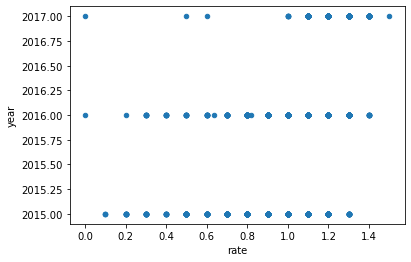

In [101]:
# thr relation between rates and years
the_main_df.plot(x='rate', y='year', kind='scatter');

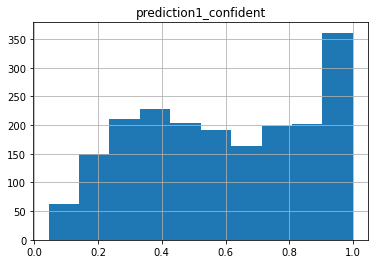

In [107]:
the_main_df.hist("prediction1_confident");

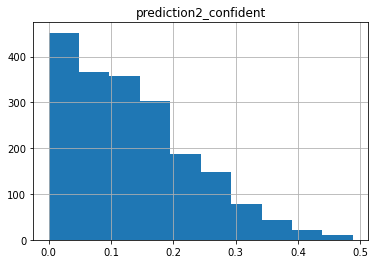

In [108]:
the_main_df.hist("prediction2_confident");

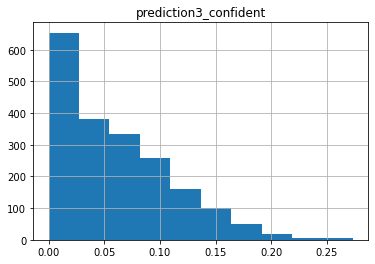

In [109]:
the_main_df.hist("prediction3_confident");

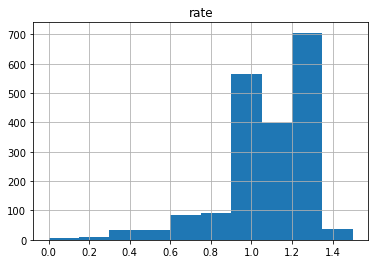

In [110]:
the_main_df.hist("rate");

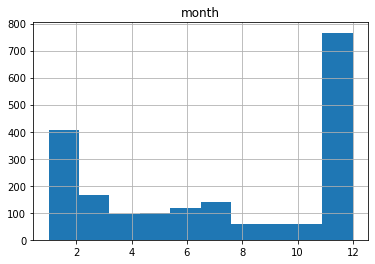

In [114]:
the_main_df.hist('month');

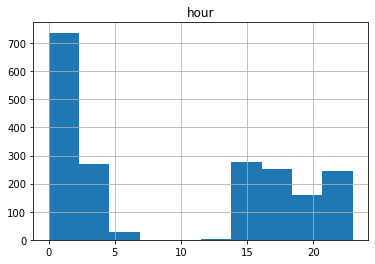

In [115]:
the_main_df.hist('hour');

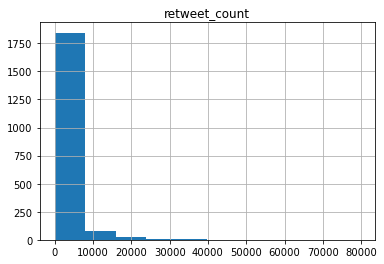

In [116]:
the_main_df.hist('retweet_count');

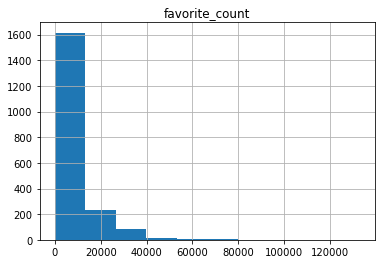

In [117]:
the_main_df.hist('favorite_count');

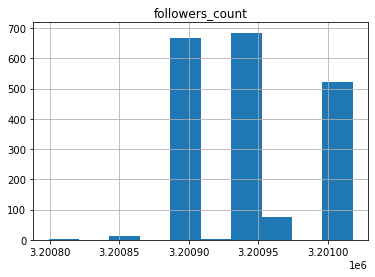

In [118]:
the_main_df.hist('followers_count');

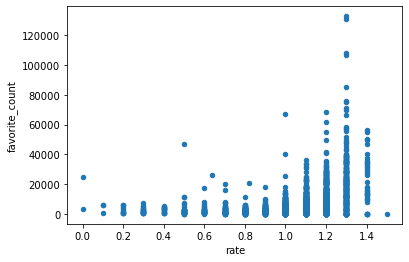

In [119]:
the_main_df.plot(x='rate', y='favorite_count', kind='scatter');

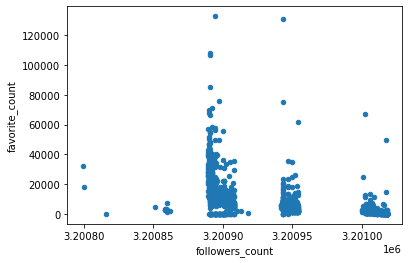

In [120]:
the_main_df.plot(x='followers_count', y='favorite_count', kind='scatter');